In [1]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow.contrib.learn as learn
from sklearn.metrics import classification_report, confusion_matrix, precision_score, accuracy_score

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
from pymongo import MongoClient
import ystockquote

In [4]:
from datetime import datetime, timedelta, timezone
import pytz
import math

# Load transcripts

In [5]:
est_tz = pytz.timezone('US/Eastern')
def utc_to_est(utc_dt):
    local_dt = utc_dt.replace(tzinfo=pytz.utc).astimezone(est_tz)
    return est_tz.normalize(local_dt)

In [6]:
def shift_time_according_to_closing_time(dt):
    if dt.hour >= 16:
        return dt + timedelta(days=1)
    return dt

In [7]:
def load_and_clean_transcripts():
    client = MongoClient('localhost', 27017)
    earnings_transcript_collection = client.python_import.earnings_transcript
    
    earnings_transcript = pd.DataFrame(list(earnings_transcript_collection.find()))
    earnings_transcript.drop('_id', axis=1, inplace=True)
    earnings_transcript['shifted_publishDate'] = earnings_transcript.apply(
        lambda row: datetime.strptime(row['publishDate'], '%Y-%m-%dT%H:%M:%SZ'), axis=1
    )
    earnings_transcript['shifted_publishDate'] = earnings_transcript.apply(
        lambda row: utc_to_est(row['shifted_publishDate']), axis=1
    )
    earnings_transcript['shifted_publishDate'] = earnings_transcript.apply(
        lambda row: shift_time_according_to_closing_time(row['shifted_publishDate']), axis=1
    )
    earnings_transcript['publishDate_str'] = earnings_transcript.apply(
        lambda row: str(row['shifted_publishDate'].date()), axis=1
    )
    earnings_transcript.set_index(['tradingSymbol', 'publishDate_str'], inplace=True)
    
    return earnings_transcript

In [8]:
earnings_transcript = load_and_clean_transcripts()

In [9]:
earnings_transcript.head(2)

,,publishDate,qAndAText,rawText,url,shifted_publishDate
tradingSymbol,publishDate_str,,,,,
A,2014-11-18,2014-11-17T22:25:00Z,,The following audio is from a conference call ...,https://seekingalpha.com/article/2675895-agile...,2014-11-18 17:25:00-05:00
AA,2014-10-09,2014-10-09T01:18:03Z,Operator [Operator instructions.] Our first qu...,Alcoa (NYSE: AA ) Q3 2014 Results Earnings Con...,https://seekingalpha.com/article/2549515-alcoa...,2014-10-09 21:18:03-04:00


In [10]:
earnings_transcript.tail(2)

publishDate  \
tradingSymbol publishDate_str                         
DLPH          2017-02-02       2017-02-02T14:17:56Z   
              2017-02-02       2017-02-02T19:57:18Z   

                                                                       qAndAText  \
tradingSymbol publishDate_str                                                      
DLPH          2017-02-02                                                           
              2017-02-02       Operator And our first question comes from the...   

                                                                         rawText  \
tradingSymbol publishDate_str                                                      
DLPH          2017-02-02       The following slide deck was published by Delp...   
              2017-02-02       Delphi Automotive Plc (NYSE: DLPH ) Q4 2016 Ea...   

                                                                             url  \
tradingSymbol publishDate_str                                                      
DLPH          2017-02-02       https://seekingalpha.com/article/4041924-delph...   
              2017-02-02       https://seekingalpha.com/article/4042152-delph...   

                                    shifted_publishDate  
tradingSymbol publishDate_str                            
DLPH          2017-02-02      2017-02-02 09:17:56-05:00  
              2017-02-02      2017-02-02 14:57:18-05:00

### Load all ticker data for transcripts

In [11]:
earnings_transcript.index.levels[0]

Index(['A', 'AA', 'AAN', 'AAON', 'AAP', 'AAPL', 'AAT', 'AAWW', 'ABAX', 'ABBV',
       ...
       'DGX', 'DHI', 'DHR', 'DHX', 'DIN', 'DIOD', 'DIS', 'DISCA', 'DKS',
       'DLPH'],
      dtype='object', name='tradingSymbol', length=200)

In [12]:
class Applyer:
    
    label = ''
    label_to_check_against = None
    
    @staticmethod
    def label_calc(row):
        
        val_to_check = 0
        if Applyer.label_to_check_against is not None:
            val_to_check = row[Applyer.label_to_check_against]
        
        if math.isnan(row[Applyer.label]) or math.isnan(val_to_check):
            return 0

        if abs(row[Applyer.label]) >= val_to_check:
            if row[Applyer.label] <= 0:
                return -1
            else:
                return 1
        else:
            return 0
    
    @staticmethod
    def all_label_calc(df):
        df['Std Dev'] = pd.Series(data=df['Close']).rolling(window=20,center=False).std()

        df['1day return'] = df['Close'].shift(-1) - df['Close']
        df['5day return'] = df['Close'].shift(-5) - df['Close']

        Applyer.label_to_check_against = None

        Applyer.label = '1day return'
        df['1day label'] = df.apply(Applyer.label_calc, axis=1)
        Applyer.label = '5day return'
        df['5day label'] = df.apply(Applyer.label_calc, axis=1)

        Applyer.label_to_check_against = 'Std Dev'

        Applyer.label = '1day return'
        df['1day significant label'] = df.apply(Applyer.label_calc, axis=1)
        Applyer.label = '5day return'
        df['5day significant label'] = df.apply(Applyer.label_calc, axis=1)

In [13]:
tickers = earnings_transcript.index.levels[0]
all_stocks = None
try:
    all_stocks = pd.read_pickle('all_stocks.pkl')
except:
    pass

print('Downloading missing stock data')

for ticker in tickers:
    if (all_stocks is not None) and (ticker in all_stocks.index):
        continue
    stock = []
    try:
        stocks = ystockquote.get_historical_prices(ticker, '2000-01-01', '2017-12-31')
    except:
        print('{} is not available on Yahoo'.format(ticker))
        continue
    print('{} ticker has {} long list'.format(ticker, len(stocks)))
    df = pd.DataFrame(stocks).transpose()
    if 'Adj Close' in df.columns:
        df['Close'] = pd.to_numeric(df['Adj Close'], errors='ignore')
    elif 'Close' in df.columns:
        df['Close'] = pd.to_numeric(df['Close'], errors='ignore')
    else:
        print('{} does not have close prices'.format(ticker))
        continue
    df.drop(axis=1, labels=[col for col in df.columns if col not in ['Close']], inplace=True)
    indexes = pd.MultiIndex.from_product([[ticker], df.index.values.tolist()], names=['tradingSymbol', 'publishDate_str'])
    df.set_index(indexes, inplace=True)
    
    Applyer.all_label_calc(df)
    df.dropna(inplace=True)
    
    if all_stocks is None:
        all_stocks = df
    else:
        all_stocks = all_stocks.append(df)
        
all_stocks.to_pickle('all_stocks.pkl')

ACE is not available on Yahoo
ACT is not available on Yahoo
ALTR is not available on Yahoo


In [14]:
all_stocks.sample(20)

,,Close,Std Dev,1day return,5day return,1day label,5day label,1day significant label,5day significant label
tradingSymbol,publishDate_str,,,,,,,,
APEI,2016-04-15,20.740000,0.588590,-0.049999,0.930000,-1,1,0,1
CVX,2005-11-21,39.720463,0.627391,0.182235,-0.998917,1,-1,0,-1
ATW,2016-05-27,10.560000,0.970949,0.110000,0.940000,1,1,0,0
ATU,2005-07-12,22.602617,0.658394,-0.073479,0.220442,-1,1,0,0
AMRI,2011-01-27,5.480000,0.161450,-0.350000,-0.610000,-1,-1,-1,-1
ALOG,2004-08-17,36.251903,0.684402,-0.137284,-0.073219,-1,-1,0,0
AAPL,2013-04-30,58.213118,2.006923,-0.458835,2.087775,-1,1,0,1
ANDE,2011-09-12,22.771799,0.778912,0.530578,1.135191,1,1,0,1
AEGN,2007-10-31,14.060000,1.109485,-0.440000,-1.610000,-1,-1,0,-1


# Merge transcripts with stock data

In [15]:
merged_data = earnings_transcript.merge(all_stocks, left_index=True, right_index=True)

In [16]:
merged_data.sample(5)

,,publishDate,qAndAText,rawText,url,shifted_publishDate,Close,Std Dev,1day return,5day return,1day label,5day label,1day significant label,5day significant label
tradingSymbol,publishDate_str,,,,,,,,,,,,,
CTS,2016-02-08,2016-02-08T20:01:07Z,Operator Thank you. [Operator Instructions]. W...,CTS Corporation (NYSE: CTS ) Q4 2015 Earnings ...,https://seekingalpha.com/article/3875726-ctss-...,2016-02-08 15:01:07-05:00,13.576122,0.595227,-0.267169,0.098950,-1,1,0,0
DGX,2011-01-26,2011-01-25T21:05:19Z,Operator [Operator Instructions] Tom Gallucci ...,Quest Diagnostics (NYSE: DGX ) Q4 2010 Earning...,https://seekingalpha.com/article/248535-quest-...,2011-01-26 16:05:19-05:00,51.643508,0.900285,0.250609,-0.268510,1,-1,0,0
DF,2014-08-11,2014-08-11T19:29:03Z,Operator Thank you. (Operator Instructions) Yo...,Dean Foods Company. (NYSE: DF ) Q2 2014 Result...,https://seekingalpha.com/article/2410935-dean-...,2014-08-11 15:29:03-04:00,14.474123,0.749845,0.171404,1.066514,1,1,0,1
CRVL,2013-10-29,2013-10-29T17:25:01Z,Operator (Operator Instructions). And there ar...,Call Start: 11:30 Call End: 11:42 CorVel Corp....,https://seekingalpha.com/article/1782862-corve...,2013-10-29 13:25:01-04:00,43.009998,2.186024,-0.269996,-2.629997,-1,-1,0,-1
AHL,2014-10-30,2014-10-30T16:39:04Z,Operator Ladies and gentlemen the floor is now...,Start Time: 09:00 End Time: 09:36 Aspen Insura...,https://seekingalpha.com/article/2618045-aspen...,2014-10-30 12:39:04-04:00,41.449951,0.554000,0.267730,0.114743,1,1,0,0


In [17]:
merged_data = merged_data[merged_data['rawText'].apply(len) > 5000]

# Create train data and test data

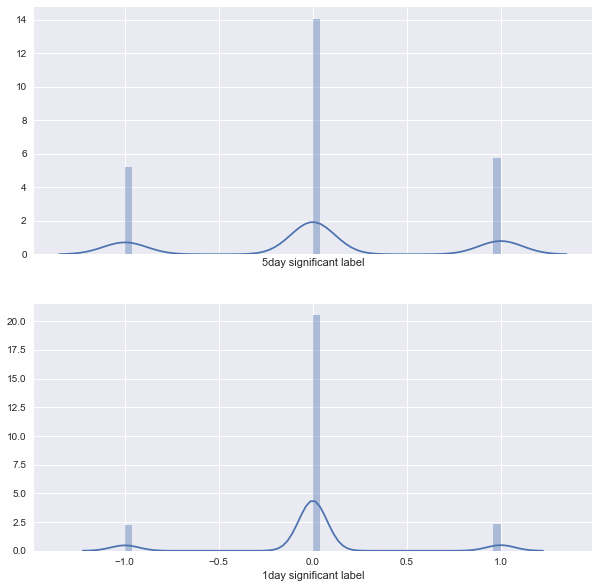

In [18]:
f, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(10, 10))
sns.distplot(merged_data['5day significant label'], ax=ax1)
sns.distplot(merged_data['1day significant label'], ax=ax2)

In [19]:
merged_data['5day significant label'].value_counts()

 0    3304
 1    1356
-1    1218
Name: 5day significant label, dtype: int64

In [20]:
# remove this!
# merged_data = merged_data[merged_data['5day significant label'] != 0]
# merged_data['5day significant label'] = merged_data.apply(lambda row: 0 if row['5day significant label'] == -1 else 1, axis=1)

In [20]:
X = merged_data['rawText']
y = merged_data['5day significant label'] + 1

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# Tf-Idf and DNN model

In [22]:
tfidf = TfidfVectorizer(max_df=0.3, min_df=10, ngram_range=(1,2), stop_words='english')

In [23]:
tfidf_vectors = tfidf.fit_transform(X_train).astype(np.float32)

In [24]:
classifier = learn.DNNClassifier(hidden_units=[50,20,10], n_classes=3, 
                                 feature_columns=[tf.contrib.layers.real_valued_column("", dimension=tfidf_vectors.shape[1])])

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_keep_checkpoint_every_n_hours': 10000, '_is_chief': True, '_keep_checkpoint_max': 5, '_save_summary_steps': 100, '_task_id': 0, '_num_ps_replicas': 0, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1
}
, '_evaluation_master': '', '_environment': 'local', '_master': '', '_task_type': None, '_tf_random_seed': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000001F4106D7C18>, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600}


In [25]:
dense_tfidf_vectors = tfidf_vectors.toarray()

In [26]:
classifier.fit(dense_tfidf_vectors, y_train, batch_size=20, steps=600)

Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat. Arguments x, y and batch_size are only
available in the SKCompat class, Estimator will only accept input_fn.
Example conversion:
  est = Estimator(...) -> est = SKCompat(Estimator(...))
Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat. Arguments x, y and batch_size are only
available in the SKCompat class, Estimator will only accept input_fn.
Example conversion:
  est = Estimator(...) -> est = SKCompat(Estimator(...))
Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat. Arguments x, y and batch_size are only
available in the SKCompat class, Estimator will only accept input_fn.
Example conversion:
  est = Estimator(...) -> est = SKCompat(Estimator(...))


C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\util\deprecation.py:247: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  equality = a == b


Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, passing a tensor or list of tags to a scalar summary op is no longer supported.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into C:\Users\neural\AppData\Local\Temp\tmpprsnv5w_\model.ckpt.
INFO:tensorflow:loss = 1.09862, step = 1
INFO:tensorflow:global_step/sec: 9.00979
INFO:tensorflow:loss = 0.778315, step = 101
INFO:tensorflow:global_step/sec: 8.67819
INFO:tensorflow:loss = 1.19813, step = 201
INFO:tensorflow:global_step/sec: 8.72517
INFO:tensorflow:loss = 0.848626, step = 301
INFO:tensorflow:global_step/sec: 8.9679
INFO:tensorflow:loss = 0.995302, step = 401
INFO:tensorflow:global_step/sec: 8.67442
INFO:tensorflow:loss = 1.12741, step = 501
INFO:tensorflow:Saving checkpoints for 600 into C:\Users\ne

DNNClassifier(params={'activation_fn': <function relu at 0x000001F458AC9510>, 'head': <tensorflow.contrib.learn.python.learn.estimators.head._MultiClassHead object at 0x000001F425886080>, 'dropout': None, 'optimizer': None, 'input_layer_min_slice_size': None, 'hidden_units': [50, 20, 10], 'feature_columns': (_RealValuedColumn(column_name='', dimension=219303, default_value=None, dtype=tf.float32, normalizer=None),), 'gradient_clip_norm': None, 'embedding_lr_multipliers': None})

In [29]:
test_vectors = tfidf.transform(X_test).astype(np.float32)

In [30]:
test_vectors = test_vectors.toarray()

In [31]:
y_predicted = list(classifier.predict(test_vectors))

Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat. Arguments x, y and batch_size are only
available in the SKCompat class, Estimator will only accept input_fn.
Example conversion:
  est = Estimator(...) -> est = SKCompat(Estimator(...))


C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\util\deprecation.py:247: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  equality = a == b


#### Confusion matrix
By definition a confusion matrix :math:`C` is such that :math:`C_{i, j}`
is equal to the number of observations known to be in group :math:`i` but
predicted to be in group :math:`j`.

In [32]:
cm = confusion_matrix(y_test, y_predicted)

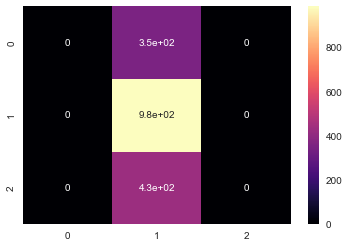

In [33]:
sns.heatmap(cm, cmap='magma', annot=True)

In [ ]:
cr = classification_report(y_test, y_predicted)
print(cr)

In [ ]:
accuracy_score(y_test, y_predicted)

In [38]:
tfidf.get_feature_names()[10000:10500]

['account value',
 'account values',
 'account ve',
 'account wins',
 'account year',
 'accountability',
 'accountable',
 'accountable care',
 'accountant',
 'accountants',
 'accounted',
 'accounted 10',
 'accounted 11',
 'accounted 18',
 'accounted 20',
 'accounted 25',
 'accounted 26',
 'accounted 30',
 'accounted 31',
 'accounted 34',
 'accounted 50',
 'accounted 70',
 'accounted approximately',
 'accounted half',
 'accounted increase',
 'accounted just',
 'accounted majority',
 'accounted million',
 'accounted nearly',
 'accounted points',
 'accounted quarter',
 'accounted roughly',
 'accounted sales',
 'accounted total',
 'accounting adjustment',
 'accounting adjustments',
 'accounting approximately',
 'accounting associated',
 'accounting basis',
 'accounting change',
 'accounting changes',
 'accounting charge',
 'accounting charges',
 'accounting finance',
 'accounting financial',
 'accounting firm',
 'accounting fixed',
 'accounting going',
 'accounting guidance',
 'accounting 